### Access to walls and boundaries

In [1]:
# input modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [2]:
# input data
df = pd.read_csv(r"root_of_file\Project\voxel_color_map_uhuman_complete_0.05_txt.txt", sep=" ")

print(df)

        x_col  y_col  z_col  r_col  g_col  b_col
0         205    685     25    250     50     50
1         680    376     51    255     23     23
2         691    685     61    124    133    141
3         818    399     61    124    133    141
4         821    653     61    124    133    141
...       ...    ...    ...    ...    ...    ...
929656    381    412     61    124    133    141
929657    381    414     61    124    133    141
929658    381    417     61    124    133    141
929659    381    420     61    124    133    141
929660    381    422     61    124    133    141

[929661 rows x 6 columns]


In [3]:
print(np.min(df['x_col']), np.max(df['x_col']))
print(np.min(df['y_col']), np.max(df['y_col']))

0 966
0 867


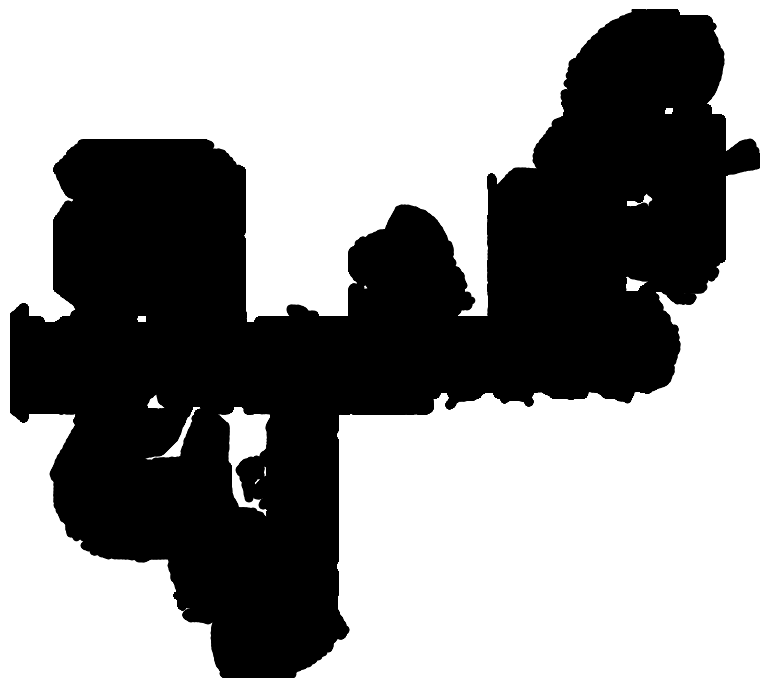

In [7]:
plt.figure(figsize=(np.max(df['x_col'])/100, np.max(df['y_col'])/100))
plt.xlim(np.min(df['x_col']), np.max(df['x_col']))
plt.ylim(np.min(df['y_col']), np.max(df['y_col']))
plt.scatter(df['x_col'], df['y_col'], s=20, c='k')
plt.axis('off')
plt.savefig("intermediate_whole.png", dpi=100)

In [5]:
# wall rgb values
r = 2
g = 103
b = 71

# filter out the walls
filtered_df = df[(df['r_col'] == 2) & (df['g_col'] == 103) & (df['b_col'] == 71)]

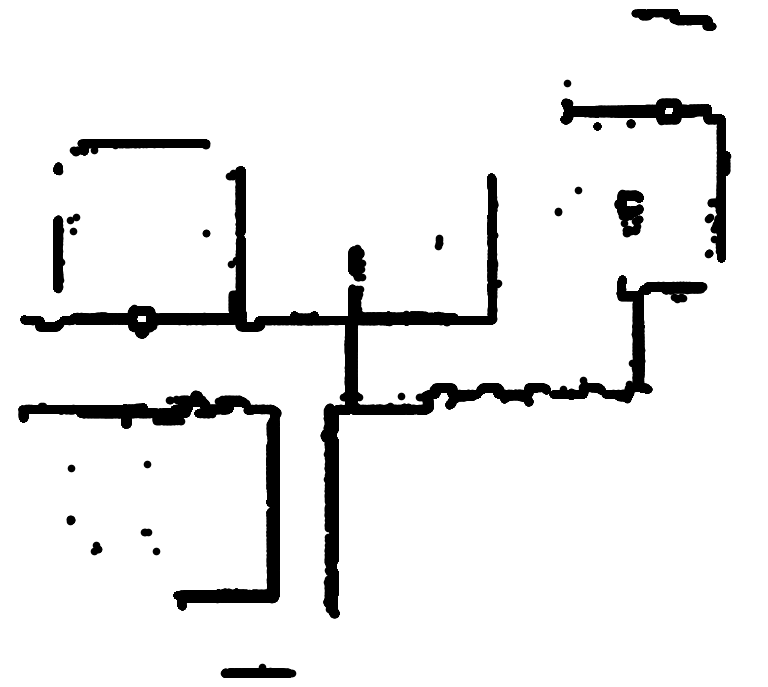

In [6]:
# plot the walls (and pillars) 
plt.figure(figsize=(9.66, 8.67))
plt.scatter(filtered_df['x_col'], filtered_df['y_col'], s=20, c='k')
plt.xlim(np.min(df['x_col']), np.max(df['x_col']))
plt.ylim(np.min(df['y_col']), np.max(df['y_col']))
plt.axis('off')
plt.savefig("intermediate_walls.png", dpi=100)

### Room Classification

In [3]:
# import dependencies
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [4]:
# import data and do size correction
img = cv.imread("intermediate_whole.png")
img_wall = cv.imread("intermediate_walls.png")
img = cv.resize(img, (966, 867), interpolation = cv.INTER_AREA)
img_wall = cv.resize(img_wall, (966, 867), interpolation = cv.INTER_AREA)

# find connected areas in whole map
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
_, thresh = cv.threshold(gray, 127, 255, cv.THRESH_BINARY)
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(thresh, connectivity=8)

# filter out all the backgrounds
thresh[(labels!=labels[0, 0])&(labels!=labels[0, -1])&(labels!=labels[-1, 0])&(labels!=labels[-1, -1])]=255
thresh[(labels==labels[0, 0])|(labels==labels[0, -1])|(labels==labels[-1, 0])|(labels==labels[-1, -1])]=0

# size correction
x_min = np.min(np.argwhere(thresh==255)[:, 0])
x_max = np.max(np.argwhere(thresh==255)[:, 0])
y_min = np.min(np.argwhere(thresh==255)[:, 1])
y_max = np.max(np.argwhere(thresh==255)[:, 1])
thresh = thresh[x_min:x_max, y_min:y_max]
img_wall = img_wall[x_min:x_max, y_min:y_max]

thresh = cv.resize(thresh, (966, 867), interpolation = cv.INTER_AREA)
img_wall = cv.resize(img_wall, (966, 867), interpolation = cv.INTER_AREA)

# find boundaries and combine it with the walls
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_wall, contours, -1, 0, 3)

# save combined image
cv.imwrite("intermediate_combined.png", img_wall)

# load conbined image
img = cv.imread("intermediate_combined.png")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
_, thresh = cv.threshold(img_gray, 127, 255, cv.THRESH_BINARY_INV)

# filter out the walls and boundaries and reduce noise
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(thresh, connectivity=8)

area_white = cv.countNonZero(thresh)
wall_idx = np.argmin(np.abs(stats[:, 4]-area_white))

# consider that the walls are all connected
filtered_wall = np.zeros_like(thresh)

filtered_wall[labels==wall_idx] = 255
filtered_img = 255 - filtered_wall

# find rooms and filter out the labels of walls and background
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(filtered_img, connectivity=8)

wall_idx = np.argmin(np.abs(stats[:, 4]-area_white))
bgd_idx = [labels[0,0], labels[0,-1], labels[-1, 0], labels[-1, -1]]

labels_list = np.array(range(num_labels))

labels_list = np.delete(labels_list, np.where(labels_list == labels[0,0]))
labels_list = np.delete(labels_list, np.where(labels_list == labels[0,-1]))
labels_list = np.delete(labels_list, np.where(labels_list == labels[-1,0]))
labels_list = np.delete(labels_list, np.where(labels_list == labels[-1,-1]))

wall_idx = np.argmin(np.abs(stats[:, 4]-area_white))
labels_list = np.delete(labels_list, np.where(labels_list == wall_idx))
stats = stats[labels_list.tolist()]

# find points inside rooms and do floodfill
x_pos = []
y_pos = []

for label in labels_list:
    x_pos.append(int(np.argwhere(labels==label)[0, 1]))
    y_pos.append(int(np.argwhere(labels==label)[0, 0]))

filtered_img = cv.cvtColor(filtered_img, cv.COLOR_GRAY2BGR)
flood_mask = np.zeros([thresh.shape[0]+2, thresh.shape[1]+2], np.uint8)

# assign each room a random color
for i in range(len(x_pos)):
    R = int(np.random.choice(range(256)))
    G = int(np.random.choice(range(256)))
    B = int(np.random.choice(range(256)))
    cv.floodFill(filtered_img, flood_mask, (x_pos[i], y_pos[i]), (R, G, B))
    print('R:', R, 'G:', G, 'B:', B, 'label:', labels[y_pos[i], x_pos[i]])

R: 71 G: 70 B: 89 label: 3
R: 87 G: 75 B: 208 label: 4
R: 201 G: 135 B: 163 label: 5
R: 121 G: 188 B: 23 label: 6
R: 98 G: 119 B: 190 label: 7
R: 189 G: 144 B: 75 label: 8
R: 159 G: 200 B: 173 label: 10
R: 37 G: 131 B: 244 label: 11
R: 75 G: 112 B: 145 label: 12
R: 59 G: 10 B: 38 label: 13
R: 64 G: 181 B: 70 label: 14
R: 41 G: 158 B: 102 label: 15
R: 138 G: 134 B: 225 label: 16
R: 233 G: 65 B: 31 label: 17
R: 178 G: 214 B: 192 label: 18
R: 142 G: 34 B: 88 label: 19
